# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [24]:
import numpy as np
import pytest
import time

def chamfer(queries: np.ndarray, vectors: np.ndarray):
        """Takes two sets of vectors and calculates chamfer
        
        O()
        """

        # (n, m) matrix of all the pairwise dot products
        dot_products = queries @ vectors.T

        # sum the max value for each query (row)
        chamfer = np.sum(np.max(dot_products, axis=1))
        return chamfer

def timed_score(score_fn, query_vecs, doc_vecs, **kwargs):
    n_q, n_d = len(query_vecs), len(doc_vecs)
    print(f"→ Running {score_fn.__name__} on {n_q} query vectors vs {n_d} doc vectors...")

    start = time.perf_counter()
    score = score_fn(query_vecs, doc_vecs, **kwargs)
    end = time.perf_counter()

    print(f"Time taken: {end - start:.6f} seconds")
    print(f"Vector comparisons (est.): {n_q * n_d:,}\n")

    return score

# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert timed_score(chamfer, A, B) == pytest.approx(1.0)
assert timed_score(chamfer, B, A) == pytest.approx(1 + np.sqrt(.5))
assert timed_score(chamfer, B, C) == pytest.approx(2)
assert timed_score(chamfer, B, B) == pytest.approx(2)
assert timed_score(chamfer, C, C) == pytest.approx(4)

→ Running chamfer on 1 query vectors vs 2 doc vectors...
Time taken: 0.000075 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 1 doc vectors...
Time taken: 0.000017 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 4 doc vectors...
Time taken: 0.000234 seconds
Vector comparisons (est.): 8

→ Running chamfer on 2 query vectors vs 2 doc vectors...
Time taken: 0.000402 seconds
Vector comparisons (est.): 4

→ Running chamfer on 4 query vectors vs 4 doc vectors...
Time taken: 0.000044 seconds
Vector comparisons (est.): 16



In [25]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, BitSamplingLSH
import time

def timed_best(best_fn, forest, a):
    start = time.perf_counter()
    score, doc = best_fn(forest, a)
    end = time.perf_counter()

    n_queries = queries.shape[0]
    total_candidates = a * n_queries
    print(f"{best_fn.__name__} took {end - start:.4f} sec, "
          f"{total_candidates:,} vector comparisons (approx)\n")
    return score, doc

def plot(x, y, xlabel):
    plt.figure()
    plt.plot(x, y, marker='o')
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Similarity Score')
    plt.title(f'Convergence of LSH approximation as {xlabel} grows')
    plt.show()

def plot_similarity_heatmap(query_vecs, doc_vecs, title="Similarity Heatmap"):
    sim_matrix = np.dot(query_vecs, doc_vecs.T)  # shape (q, m)

    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("bwr")  # blue-white-red diverging colormap
    vmax = np.abs(sim_matrix).max()  # ensure center is zero
    plt.imshow(sim_matrix, aspect='auto', cmap=cmap, vmin=-vmax, vmax=vmax)
    plt.colorbar(label='Dot Product Similarity')
    plt.xlabel("Document Vector Index")
    plt.ylabel("Query Vector Index")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def experiment(variable, values, defaults, build, best):
        sims, docs = [], []
        for value in values:
                parameters = defaults.copy()
                parameters[variable] = value
                forest = build(parameters['l'], parameters['k'], parameters['km'])
                sim, doc = timed_best(best, forest, parameters['a'])
                sims.append(sim)
                docs.append(doc)
        print(f"Finished experiment: {variable}")
        return sims, docs


def simple_approximate_best(forests: list[LSHForest], a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


n = 1000                                 # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}

# Get normalized document and query vectors
vectors = rng.normal(size=(n, m, d)).astype(np.float32)
vectors /= np.linalg.norm(vectors, axis=-1, keepdims=True)

queries = rng.normal(size=(q, d)).astype(np.float32)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

# Constructors for each forest type
def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(BitSamplingLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(vectors[doc])
        return single_doc_forests


def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(BitSamplingLSH(d), l, k, km)
        multi_doc_forest.batch_insert(vectors)
        return multi_doc_forest

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(best)




(15.287652015686035, 63)


simple_approximate_best took 0.9609 sec, 375 vector comparisons (approx)

simple_approximate_best took 4.6554 sec, 375 vector comparisons (approx)

simple_approximate_best took 8.2493 sec, 375 vector comparisons (approx)

simple_approximate_best took 16.0009 sec, 375 vector comparisons (approx)

simple_approximate_best took 30.3633 sec, 375 vector comparisons (approx)

Finished experiment: l


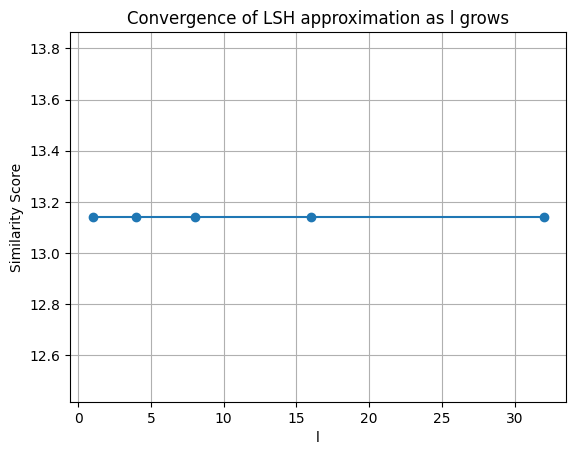

Best l = 1 → doc #614


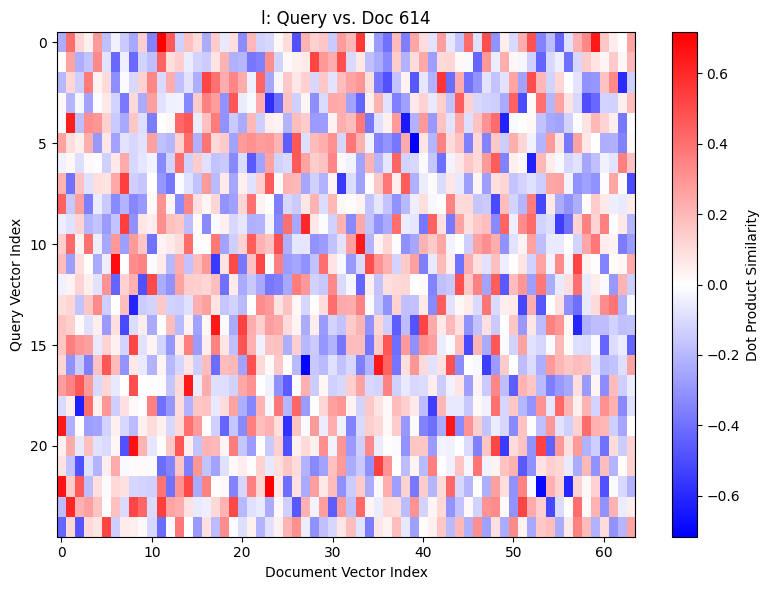

simple_approximate_best took 7.7730 sec, 375 vector comparisons (approx)

simple_approximate_best took 8.2143 sec, 375 vector comparisons (approx)

simple_approximate_best took 9.2566 sec, 375 vector comparisons (approx)

simple_approximate_best took 11.6005 sec, 375 vector comparisons (approx)

simple_approximate_best took 15.8310 sec, 375 vector comparisons (approx)

Finished experiment: k


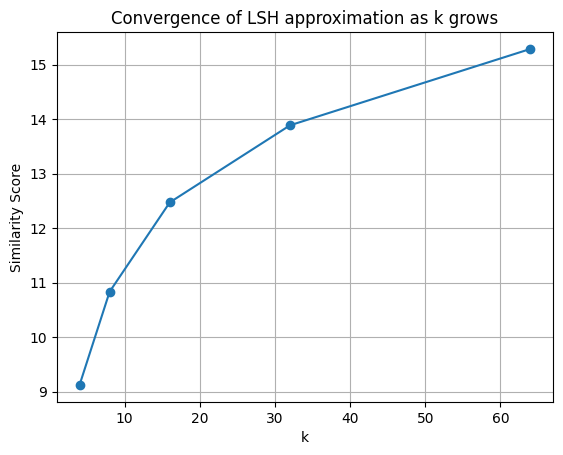

Best k = 64 → doc #63


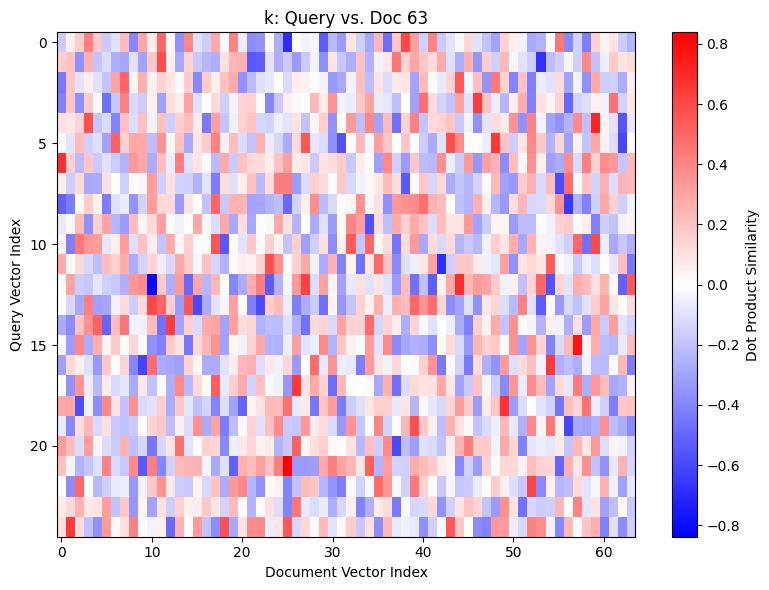

simple_approximate_best took 3.0124 sec, 375 vector comparisons (approx)

simple_approximate_best took 5.4164 sec, 375 vector comparisons (approx)

simple_approximate_best took 9.8942 sec, 375 vector comparisons (approx)

simple_approximate_best took 19.9774 sec, 375 vector comparisons (approx)

simple_approximate_best took 48.5416 sec, 375 vector comparisons (approx)

Finished experiment: km


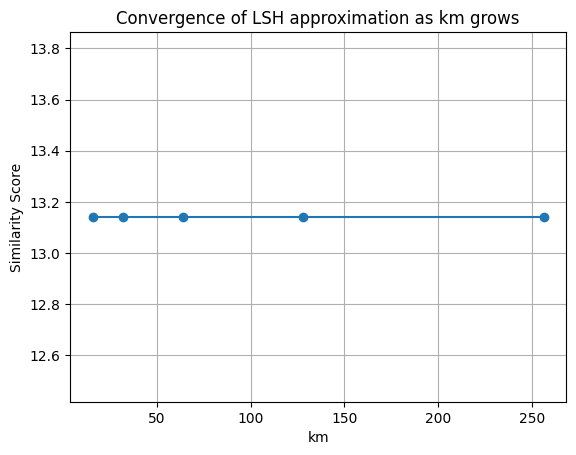

Best km = 16 → doc #614


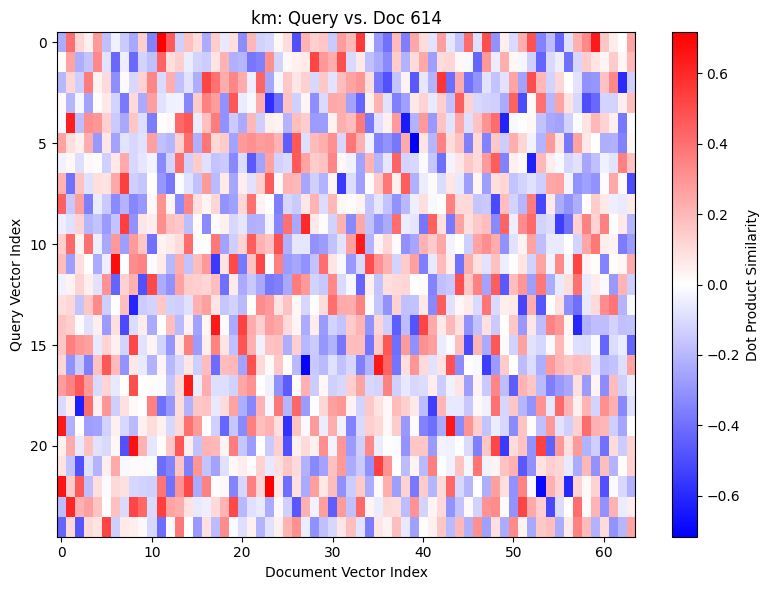

simple_approximate_best took 10.4439 sec, 25 vector comparisons (approx)

simple_approximate_best took 10.5083 sec, 100 vector comparisons (approx)

simple_approximate_best took 9.6820 sec, 200 vector comparisons (approx)

simple_approximate_best took 10.2218 sec, 400 vector comparisons (approx)

simple_approximate_best took 9.7833 sec, 800 vector comparisons (approx)

Finished experiment: a


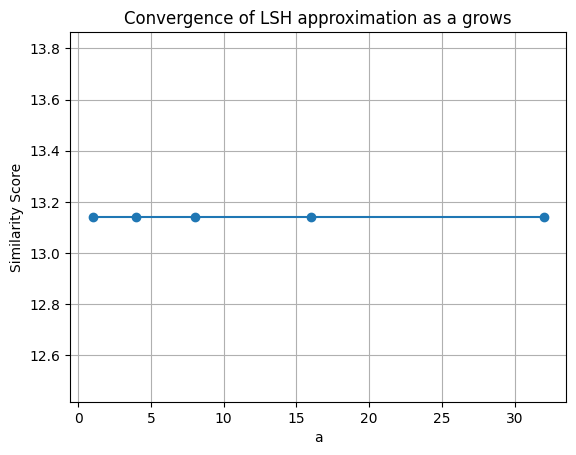

Best a = 1 → doc #614


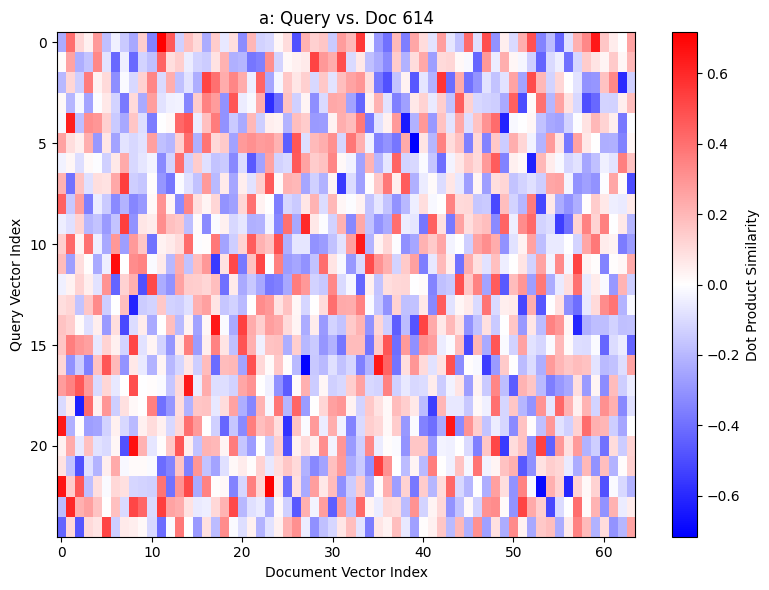

In [26]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, build_simple_lsh, simple_approximate_best)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")


multidoc_approximate_best took 0.6699 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6632 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6389 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6495 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.7147 sec, 375 vector comparisons (approx)

Finished experiment: l
multidoc_approximate_best took 0.3377 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6220 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.5483 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 1.1631 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 1.8441 sec, 375 vector comparisons (approx)

Finished experiment: k
multidoc_approximate_best took 0.7483 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6813 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.6672 sec,

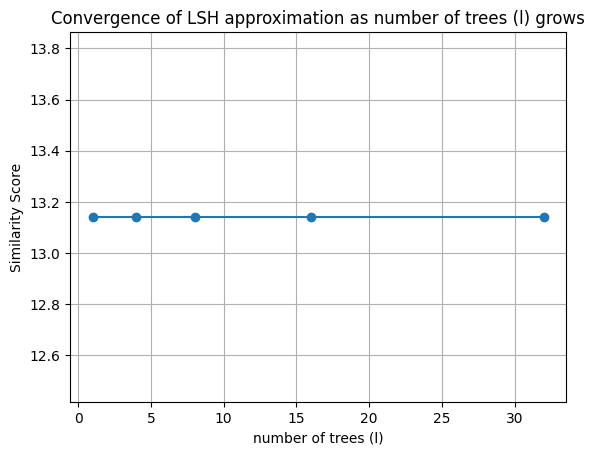

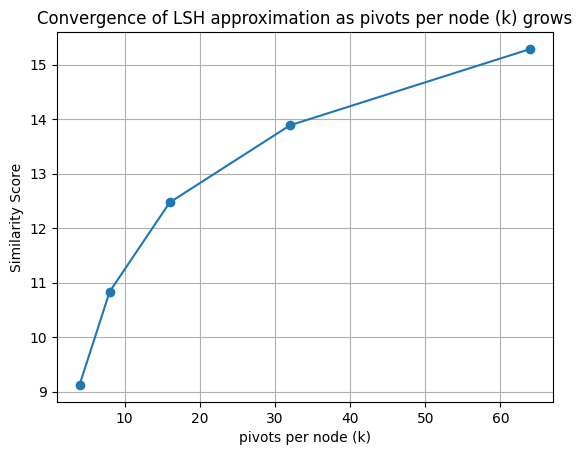

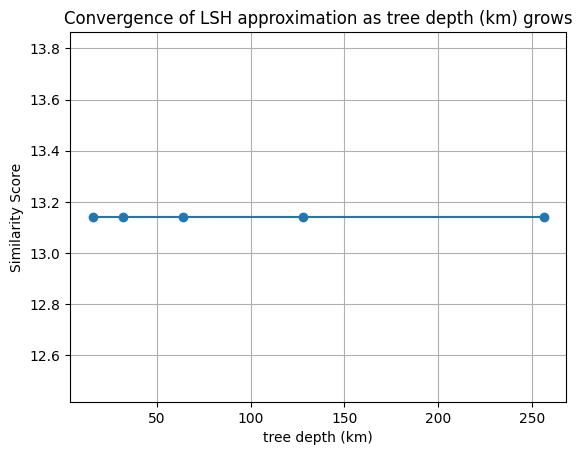

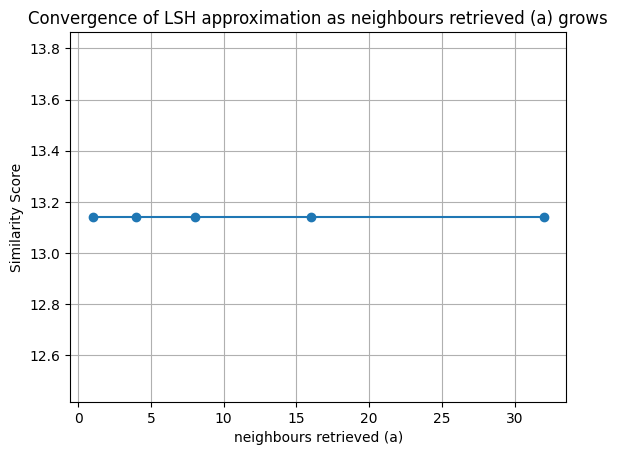

In [27]:

# Evaluate multi-doc
results = {var: experiment(var, vals, defaults, build_multidoc_lsh, multidoc_approximate_best) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')
